# Actividad 3 | Aprendizaje supervisado y no supervisado

## Introducción Teórica

El aprendizaje automatico es una disciplina de la inteligencia artificial que permite a los sistemas aprender de la experiencia y mejorar su desempeño sin ser explicitamente programados y se clasifica en dos paradigmas: supervisado y no supervisado.

En el aprendizaje supervisado se entrena un modelo con datos etiquetados, de modo que pueda predecir o clasificar nueva información es idóneo cuando existen variavles de salida bien definidas. En cambio, el aprendizaje no supervisado trabaja sobre datos sin etiquetas para descubrir la estructura oculta, patrones o agrupaciones intrínsecas.

### Algoritmos implementados en PySpark

#### Aprendizaje Supervisado

Dependiendo de la tarea y el tipo de problema se pueden classificar los algoritmos implementados en PySpark.

| Tipo de problema         | Métodos soportados                                                                                     |
|--------------------------|--------------------------------------------------------------------------------------------------------|
| Clasificación Binaria    | linear SVMs, logistic regression, decision trees, random forests, gradient-boosted trees, naive Bayes |
| Clasificación Multiclase | logistic regression, decision trees, random forests, naive Bayes                                       |
| Regresión                | linear least squares, Lasso, ridge regression, decision trees, random forests, gradient-boosted trees, isotonic regression |

#### Aprendizaje No Supervisado

- K-Means
- Bisecting K-Means
- Gaussian Mixture
- PCA
- Latent Dirichlet Allocation (LDA)

## Seleción y Limpieza de Datos

In [1]:
import os
import multiprocessing

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pyspark.sql.functions as F

from scipy.stats import gaussian_kde

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import StructType, StructField, DateType, IntegerType, StringType, DoubleType, BooleanType

from pyspark.ml.stat import Summarizer
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.clustering import LDA, LocalLDAModel, KMeans, KMeansModel
from pyspark.ml.regression import LinearRegression, LinearRegressionModel, GBTRegressor, GBTRegressionModel
from pyspark.ml.feature import StandardScaler, StringIndexer, OneHotEncoder, VectorAssembler, QuantileDiscretizer

In [2]:
# How much memory from the available in the machine I'm able to use
EXECUTOR_MEMORY = "100G"
DRIVER_MEMORY = "20G"

In [3]:
spark = (
    SparkSession.builder.appName("flights")
    .config("spark.executor.memory", EXECUTOR_MEMORY)
    .config("spark.driver.memory", DRIVER_MEMORY)
    .getOrCreate()
)

spark.sparkContext.setLogLevel('ERROR')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/24 18:55:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# This should be changed according to the environment
filepath = "./data/flights"

In [5]:
filenames = [ f"Combined_Flights_{y}.csv" for y in range(2018, 2023) ]

### Carga de Archivos

Schema para el dataset de vuelos

In [6]:
schema = StructType(
    [
        StructField("FlightDate", DateType(), True),
        StructField("Airline", StringType(), True),
        StructField("Origin", StringType(), True),
        StructField("Dest", StringType(), True),
        StructField("Cancelled", BooleanType(), True),
        StructField("Diverted", StringType(), True),
        StructField("CRSDepTime", IntegerType(), True),
        StructField("DepTime", DoubleType(), True),
        StructField("DepDelayMinutes", DoubleType(), True),
        StructField("DepDelay", DoubleType(), True),
        StructField("ArrTime", DoubleType(), True),
        StructField("ArrDelayMinutes", DoubleType(), True),
        StructField("AirTime", DoubleType(), True),
        StructField("CRSElapsedTime", DoubleType(), True),
        StructField("ActualElapsedTime", DoubleType(), True),
        StructField("Distance", DoubleType(), True),
        StructField("Year", IntegerType(), True),
        StructField("Quarter", IntegerType(), True),
        StructField("Month", IntegerType(), True),
        StructField("DayofMonth", IntegerType(), True),
        StructField("DayOfWeek", IntegerType(), True),
        StructField("Marketing_Airline_Network", StringType(), True),
        StructField("Operated_or_Branded_Code_Share_Partners", StringType(), True),
        StructField("DOT_ID_Marketing_Airline", StringType(), True),
        StructField("IATA_Code_Marketing_Airline", StringType(), True),
        StructField("Flight_Number_Marketing_Airline", StringType(), True),
        StructField("Operating_Airline", StringType(), True),
        StructField("DOT_ID_Operating_Airline", StringType(), True),
        StructField("IATA_Code_Operating_Airline", StringType(), True),
        StructField("Tail_Number", StringType(), True),
        StructField("Flight_Number_Operating_Airline", StringType(), True),
        StructField("OriginAirportID", StringType(), True),
        StructField("OriginAirportSeqID", StringType(), True),
        StructField("OriginCityMarketID", StringType(), True),
        StructField("OriginCityName", StringType(), True),
        StructField("OriginState", StringType(), True),
        StructField("OriginStateFips", StringType(), True),
        StructField("OriginStateName", StringType(), True),
        StructField("OriginWac", StringType(), True),
        StructField("DestAirportID", StringType(), True),
        StructField("DestAirportSeqID", StringType(), True),
        StructField("DestCityMarketID", StringType(), True),
        StructField("DestCityName", StringType(), True),
        StructField("DestState", StringType(), True),
        StructField("DestStateFips", StringType(), True),
        StructField("DestStateName", StringType(), True),
        StructField("DestWac", StringType(), True),
        StructField("DepDel15", StringType(), True),
        StructField("DepartureDelayGroups", StringType(), True),
        StructField("DepTimeBlk", StringType(), True),
        StructField("TaxiOut", DoubleType(), True),
        StructField("WheelsOff", DoubleType(), True),
        StructField("WheelsOn", DoubleType(), True),
        StructField("TaxiIn", DoubleType(), True),
        StructField("CRSArrTime", IntegerType(), True),
        StructField("ArrDelay", DoubleType(), True),
        StructField("ArrDel15", StringType(), True),
        StructField("ArrivalDelayGroups", StringType(), True),
        StructField("ArrTimeBlk", StringType(), True),
        StructField("DistanceGroup", StringType(), True),
        StructField("DivAirportLandings", StringType(), True),
    ]
)

In [7]:
def read_files_from(path: str, files: list[str], schema) -> DataFrame:
    import functools
    df = spark.createDataFrame([], schema=schema)
    dataframes = [
        spark.read.csv(f"{filepath}/{filename}", header=True, schema=schema)
        for filename in files
    ]
    return functools.reduce(DataFrame.unionAll, dataframes, df)

In [8]:
df = read_files_from(filepath, filenames, schema)

### Limpieza de Datos

In [9]:
# number of original rows
df.count()

29193782

In [10]:
# drop rows with null values
clean_df = df.dropna()

# drop columns with null values
clean_df = clean_df.na.drop()

# drop duplicated rows
clean_df = clean_df.dropDuplicates()

# number of rows after cleaning
clean_df.count()

28339510

Definition of categorical columns and continuous columns

In [11]:
column = "ArrDelay"


continuous_cols = [
    el.name
    for el in df.schema
    if isinstance(el.dataType, (DoubleType, IntegerType))
    and el.name not in ["Year", "Quarter", "Month", "DayofMonth", "DayOfWeek"]
]

categorica_cols = [
    "Marketing_Airline_Network",
    "Operating_Airline",
    "OriginAirportID",
    "DestAirportID",
    "OriginCityName",
    "DestCityName",
    "DayOfWeek",
    "Month",
    "DistanceGroup",
]

In [12]:
vec = VectorAssembler(outputCol="features", inputCols=continuous_cols)

In [13]:
clean_df = vec.transform(clean_df)
clean_df = clean_df.cache()

In [14]:
def calculate_stats(func, df: DataFrame, feature: str, columns: list):
    temp_df = df.select(func(df[feature])).collect()
    return { k: v for k, v in zip(columns, temp_df[0][0].toArray())}

### Valores Típicos

Calculamos valores típicos (promedio)

In [15]:
mean_dict = calculate_stats(Summarizer.mean, clean_df, 'features', continuous_cols)

Calculamos valores típicos (desviacion estandar)

In [16]:
std_dict = calculate_stats(Summarizer.std, clean_df, 'features', continuous_cols)

Calculamos valores típicos (max)

In [17]:
max_dict = calculate_stats(Summarizer.max, clean_df, 'features', continuous_cols)

Calculamos valores típicos (min)

In [18]:
min_dict = calculate_stats(Summarizer.min, clean_df, 'features', continuous_cols)

### Selección de los Datos

Calculamos la distribucion de la variable de dependiente, Arrival Delay

 - Para calcular el Lower Bound/Upper Bound de la media se resta/suma una desviación estándar.
 - La area es el computo de la integral sobre la función de densidad de probabilidad (PDF) sobre un intervalo rectangular, en este caso el intervalo es Lower Bound y Upper Bound

In [19]:
def plot(df, column, mean_dict, std_dict, bins=40):
    arr_delay_df = df.select(column)
    data = arr_delay_df.toPandas().to_numpy().reshape(-1)

    x = np.linspace(min_dict[column], max_dict[column], 100)
    kernel = gaussian_kde(data)

    infmin = mean_dict[column] - std_dict[column]
    infmax = mean_dict[column] + std_dict[column]

    area = kernel.integrate_box(infmin, infmax)

    plt.plot(x, kernel(x), label="KDE")
    sns.histplot(data, stat="density", bins=bins, kde=False, label="Datos")

    handles, labels = plt.gca().get_legend_handles_labels()
    patch1 = mpatches.Patch(color='r', label=f'Lower Bound {round(infmin, 2)}')
    patch2 = mpatches.Patch(color='g', label=f'Upper Bound {round(infmax, 2)}')
    patch3 = mpatches.Patch(color='b', label=f'Area between LB & UB {round(area * 100, 2)}%')
    handles.append(patch1)
    handles.append(patch2)
    handles.append(patch3)

    plt.legend(handles=handles)

    plt.axvline(x=infmin, color='r', linestyle=':', linewidth=1.7)
    plt.axvline(x=infmax, color='g', linestyle=':', linewidth=1.7)
    plt.xlabel("Arrival Delay")
    plt.show()

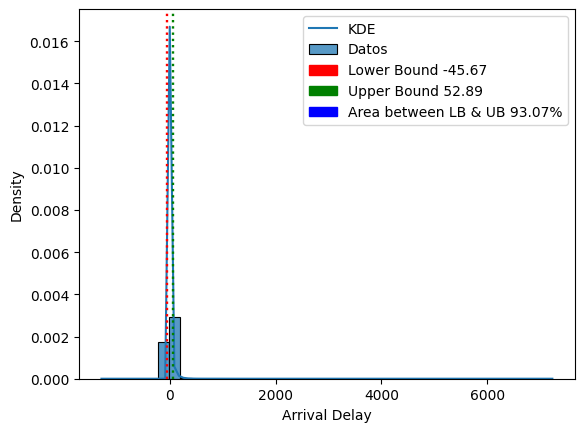

In [20]:
plot(clean_df, column=column, mean_dict=mean_dict, std_dict=std_dict)

Realizamos una estratificación en la variable Arrival Delay (ArrDelay) puesto que sera nuestra variable de salida y sobre Día de la Semana (DayOfWeek) ya que encontramos un patrón en el que los vuelos son mas frequentes en ciertos dias de la semana.

In [21]:
num_bins = 5

# Create a Discrete output over a continuous column
quantile_discretizer = QuantileDiscretizer(numBuckets=num_bins, inputCol=column, outputCol=f"{column}_binned")
clean_bin_df = quantile_discretizer.fit(clean_df).transform(clean_df)

In [22]:
# Create a new column with values of ArrDelay and DayOfWeek
clean_bin_df_with_key = clean_bin_df.withColumn("stratum_value", F.concat_ws("_", f"{column}_binned", "DayOfWeek"))

In [23]:
stratum_counts = clean_bin_df_with_key.groupBy("stratum_value").count().collect()
total_count = clean_bin_df_with_key.count()

Se obtiene una muestra del dataset original

In [24]:
factor = .3

In [25]:
stratum_fractions = {
    row[f"stratum_value"]: factor * (row["count"] / total_count)
    for row in stratum_counts
}

stratum_fractions

{'2.0_5': 0.008540408779121446,
 '4.0_1': 0.009403193633199726,
 '4.0_2': 0.007838297133577822,
 '1.0_5': 0.00938386372947168,
 '1.0_2': 0.009569085704022404,
 '3.0_1': 0.009066158871483663,
 '3.0_2': 0.008202633002476048,
 '4.0_5': 0.010070678709688348,
 '3.0_3': 0.00857913210214291,
 '0.0_4': 0.00735406504911341,
 '2.0_6': 0.0072890886257384125,
 '3.0_4': 0.009397339615257991,
 '4.0_3': 0.00812623436326175,
 '0.0_3': 0.007941933364408911,
 '1.0_3': 0.009563263443863355,
 '1.0_7': 0.009561643796946384,
 '0.0_7': 0.007854101923427751,
 '0.0_1': 0.007933570481635004,
 '3.0_5': 0.009509920954878895,
 '1.0_4': 0.009399986097148469,
 '2.0_7': 0.008262655211752073,
 '1.0_1': 0.009804590834492198,
 '2.0_3': 0.008183186653544821,
 '2.0_1': 0.008518178331241437,
 '4.0_6': 0.0072943815895193664,
 '1.0_6': 0.008765211536826148,
 '2.0_2': 0.00802232289831405,
 '2.0_4': 0.008459881628158002,
 '0.0_2': 0.0080641902418214,
 '3.0_6': 0.007465598381905685,
 '3.0_7': 0.008851613877586451,
 '0.0_5': 0.0

In [26]:
# create the sample
sample_df = clean_bin_df_with_key.sampleBy(f"stratum_value", fractions=stratum_fractions)

# Repartition the DataFrame
sample_df = sample_df.drop("stratum_value").coalesce(multiprocessing.cpu_count()).cache()

In [27]:
# Size of the sample
sample_df.count()

245189

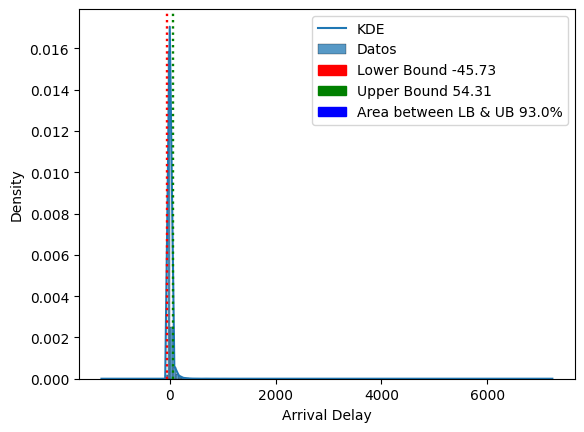

In [28]:
# Calculate mean and std dev over the sample df
sample_mean_dict = calculate_stats(Summarizer.mean, sample_df, 'features', continuous_cols)
sample_std_dict = calculate_stats(Summarizer.std, sample_df, 'features', continuous_cols)

# Plot again to test if the distribution is similar to the population distribution.
plot(sample_df, column=column, mean_dict=sample_mean_dict, std_dict=sample_std_dict)

## Preparación de los Datos

Preparamos los datos, usamos las siguientes clases StringIndexer, OneHotEncoder y StandardScaler

In [29]:
sample_df = sample_df.drop('features')
sample_df = sample_df.drop('ArrDelay_binned')

In [30]:
input_con_cols = [col for col in continuous_cols if col not in [f"{column}"]]
input_cat_cols = [f"{col}_onehot" for col in categorica_cols]

In [31]:
indexer = StringIndexer(
    inputCols=categorica_cols,
    outputCols=[f"{col}_index" for col in categorica_cols],
    handleInvalid="keep",
)

encoder = OneHotEncoder(
    inputCols=[f"{col}_index" for col in categorica_cols],
    outputCols=input_cat_cols,
    handleInvalid="keep",
)

assembler2 = VectorAssembler(inputCols=input_con_cols, outputCol="con_features")

scaler = StandardScaler(inputCol="con_features", outputCol="con_scaled_features")

final_assembler = VectorAssembler(
    inputCols=["con_scaled_features", *input_cat_cols], outputCol="features"
)

In [32]:
sample_df = indexer.fit(sample_df).transform(sample_df)
sample_df = encoder.fit(sample_df).transform(sample_df)
sample_df = assembler2.transform(sample_df)
sample_df = scaler.fit(sample_df).transform(sample_df)
sample_df = final_assembler.transform(sample_df)

In [33]:
# show the features column as a spare vector representation
sample_df.select('features').show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                                            |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [34]:
sample_df = sample_df.withColumnRenamed(column, "label")

In [35]:
# Separate into train and test splits
train_df, test_df = sample_df.select("features", "label").randomSplit([0.8, 0.2])
train_df.count(), test_df.count()

(196011, 49178)

## Modelo Supervisado.

In [ ]:
save_folder = './models'

### Entramiento del Modelo Punto de Referencia

In [ ]:
# Model instantiation
model = LinearRegression(maxIter=25)

In [38]:
# Fit the model the sample train
model = model.fit(train_df)

In [39]:
# Save the model to a local disk
model.write().overwrite().save(os.path.join(save_folder, 'glr'))

### Evaluación del Modelo Punto de Referencia

In [40]:
model2 = LinearRegressionModel.load(os.path.join(save_folder, 'glr'))

In [41]:
test_pred_df = model2.evaluate(test_df)

In [42]:
test_pred_df.predictions.select('label', 'prediction').show(truncate=False)

+-----+------------------+
|label|prediction        |
+-----+------------------+
|25.0 |22.522383642953425|
|54.0 |51.040336380622776|
|413.0|420.61905303745925|
|7.0  |5.54485161380633  |
|68.0 |68.76029453698631 |
|27.0 |24.897782477452704|
|9.0  |5.112910022395948 |
|13.0 |8.905864602402264 |
|7.0  |1.0171786834792655|
|41.0 |38.637862033131   |
|117.0|114.4446272357054 |
|84.0 |89.9179450002753  |
|108.0|106.09424792237962|
|22.0 |17.248017114924135|
|3.0  |0.8976526073274691|
|17.0 |13.57088074908879 |
|53.0 |54.93669808770592 |
|31.0 |28.109853662951505|
|225.0|237.0124600733191 |
|48.0 |40.38843175847393 |
+-----+------------------+
only showing top 20 rows



In [43]:
evaluator = RegressionEvaluator(metricName="rmse")

rmse_lr = evaluator.evaluate(test_pred_df.predictions)
mae = evaluator.evaluate(test_pred_df.predictions, {evaluator.metricName: "mae"})

print("RMSE: %.3f" % rmse_lr)
print("MAE: %.3f" % mae)

RMSE: 3.384
MAE: 2.632


Se obtuvieron las metricas RMSE y MAE que nos dan una idea del error del modelo, veamos si podemos mejorar el desempeño usando otro modelo.

### Entrenamiento del Modelo Alternativo

In [44]:
model3 = GBTRegressor(maxDepth=15, maxBins=64, maxIter=15)

In [45]:
model3 = model3.fit(train_df)

In [46]:
model3.write().overwrite().save(os.path.join(save_folder, 'gbt'))

### Prueba del Modelo Alternativo

In [47]:
model4 = GBTRegressionModel.load(os.path.join(save_folder, 'gbt'))

In [48]:
test_pred_df = model4.transform(test_df)

In [49]:
test_pred_df.select('label', 'prediction').show(truncate=False)

+-----+------------------+
|label|prediction        |
+-----+------------------+
|25.0 |25.001552322668104|
|54.0 |53.979025297578296|
|413.0|282.372738373881  |
|7.0  |6.932306341492308 |
|68.0 |63.22809805522175 |
|27.0 |27.06211420996647 |
|9.0  |8.994778806234663 |
|13.0 |12.97302212346497 |
|7.0  |6.991768134751001 |
|41.0 |41.03889633975907 |
|117.0|116.34195975870527|
|84.0 |79.18262582693006 |
|108.0|116.3159601964466 |
|22.0 |21.983047759392477|
|3.0  |3.1152931439055034|
|17.0 |16.94744430015934 |
|53.0 |52.973513218366385|
|31.0 |30.9833176274318  |
|225.0|173.94436055100914|
|48.0 |47.980878510953204|
+-----+------------------+
only showing top 20 rows



In [50]:
evaluator = RegressionEvaluator(metricName="rmse")

rmse_lr = evaluator.evaluate(test_pred_df)
mae = evaluator.evaluate(test_pred_df, {evaluator.metricName: "mae"})

print("RMSE: %.3f" % rmse_lr)
print("MAE: %.3f" % mae)

RMSE: 13.618
MAE: 2.722


## Modelo No Supervisado

### Entrenamiento del Modelo

In [55]:
model5 = KMeans(k=7, maxIter=15)

In [56]:
model5 = model5.fit(train_df)

In [57]:
model5.write().overwrite().save(os.path.join(save_folder, 'kmeans'))

### Prueba del Modelo

In [58]:
model6 = KMeansModel.load(os.path.join(save_folder, 'kmeans'))

In [59]:
# predict the model on test df
test_pred_df = model6.transform(test_df)

In [60]:
evaluator = ClusteringEvaluator()

La métrica Silhouette es una medida para validar la consistencia dentro de los clústeres. Su valor oscila entre 1 y -1, donde un valor cercano a 1 indica que los puntos de un clúster están muy próximos entre sí y alejados de los puntos de los demás clústeres.

In [65]:
metric = evaluator.evaluate(test_pred_df)

print("Silhouette: %.3f" % metric)

Silhouette: 0.147
